# Sentiment Analysis with Neural Network and GloVe Embeddings

## Imports

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import string
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import torch.nn.functional as nnf
from sklearn.metrics import roc_curve,classification_report,auc
from sklearn.preprocessing import label_binarize
from numpy import interp
from itertools import cycle
import warnings
import io

## Neural Netwrok Class

In [ ]:
#Neural Network with 3 nodes
class NeuralNetwork(nn.Module):

    def __init__(self, D_in, H1, H2, H3, D_out):

        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.ReLU61 = nn.ReLU6()
        self.linear2 = nn.Linear(H1, H2)
        self.ReLU62 = nn.ReLU6()
        self.linear3 = nn.Linear(H2,H3)
        self.ReLU63 = nn.ReLU6()
        self.linear4 = nn.Linear(H3, D_out)

    def forward(self, x):

        H1 = self.linear1(x)
        H2 = self.ReLU61(H1)
        H3 = self.linear2(H2)
        H4 = self.ReLU62(H3)
        H5 = self.linear3(H4)
        H6 = self.ReLU63(H5)
        out = self.linear4(H6)

        return  out

## Helper Functions

In [ ]:
#function removeSpecialChars to remove all special characters from text
def removeSpecialChars(text):

    text = re.sub(r'[^a-zA-z0-9\s]','',text)
    return text

#function transform to clean all data from reviews column
def transform(data):

    data = data.str.lower()
    data = data.apply(lambda x:''.join([i for i in x if i not in string.punctuation])) #remove !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~
    data = data.apply(removeSpecialChars)
    data = data.apply(lambda x: re.compile(r'<[^>]+>').sub('', x))

    return data

#fix data sets with glove6b text file
def fixSets(data,maxlen):

    averageReviews = []

    for i,sentence in enumerate(data['review']):

        weightMatrix = np.zeros((len(sentence),maxlen))

        for j,word in enumerate(sentence):

            if word in embeddingsIndex:
                weightMatrix[j] = embeddingsIndex[word]

        averageReviews.append(np.mean(weightMatrix,axis=0))

    return np.array(averageReviews)

#make ratings binary with 0 being negative and 1 being positive
def ratingToBinary(data) :

  temp = []

  for i in data["rating"]:

    if i <= 4.0:
      temp.append(0)

    else:
      temp.append(1)

  return temp

def fixBatchY(batch) :
  yBatchFix = []

  for i in batch :
    if i == [1] :

      yBatchFix.append([0,1])

    else :

      yBatchFix.append([1,0])

  return yBatchFix

#make item 1-dimensional
def to1D(item) :

  temp = [[item[i][0],item[i][1]].index(max([item[i][0],item[i][1]]))for i in range(len(item))]
  return temp

## Data Filtering Function

In [ ]:
#filter datasets , call function transform , ratingtoBinary , tokenize review columns ,  call fixSets function and tensor our data . Reeturns x,y variables for training and validation
def filteringData(trainingData, validationData) :

  xTrain = trainingData['review']
  yTrain = trainingData['rating']

  xTest = validationData['review']
  yTest  = validationData['rating']

  xTrain = transform(trainingData['review'])
  xTest = transform(validationData['review'])
  tempTrainingData = ratingToBinary(trainingData)
  yTrain = pd.DataFrame({'rating':tempTrainingData})
  tempTestData = ratingToBinary(validationData)
  yTest = pd.DataFrame({'rating':tempTestData})

  trainingData['review'] = [word_tokenize(i) for i in trainingData['review']]
  validationData['review'] = [word_tokenize(i) for i in validationData['review']]

  xTrainGlove = fixSets(pd.DataFrame(trainingData),maxLength)
  xTestGlove = fixSets(pd.DataFrame(validationData),maxLength)
  xTrainGlove  = torch.tensor(xTrainGlove)
  xTestGlove = torch.tensor(xTestGlove)
  yTrain = torch.squeeze(torch.from_numpy(yTrain.to_numpy()).float())
  yTest = torch.squeeze(torch.from_numpy(yTest.to_numpy()).float())

  return xTrainGlove, yTrain, xTestGlove, yTest

## Curve plotting Function

In [ ]:
#function to print classification report and plot roc curves , accuracy-epoch and loss-epoch
def plottingCurves(yTest, trainingLoss, validationLoss, trainingAccuracy, validationAccuracy, xTestGlove, classesnmb) :

  print("Ploting neural model")
  figure, axes = plt.subplots(ncols=2,figsize = (15, 10))
  axes[1].plot(trainingLoss)
  axes[1].plot(validationLoss)
  axes[1].set_title('Loss - Epoch')
  axes[1].set_ylabel('Loss')
  axes[1].set_xlabel('Epoch')
  axes[1].legend(['training','validation'])



  axes[0].plot(trainingAccuracy)
  axes[0].plot(validationAccuracy)
  axes[0].set_title('Accuracy - Epoch ')
  axes[0].set_ylabel('Accuracy')
  axes[0].set_xlabel('Epoch')
  axes[0].legend(['training','validation'])
  figure.tight_layout()

  warnings.filterwarnings('always')

  print("\nNeural model classification report :\n")

  yPredValidation = model.forward(xTestGlove.float())
  yPredValidation = torch.squeeze(yPredValidation)
  yPred1DValidation = to1D(yPredValidation)
  yPred1DValidation = torch.tensor(yPred1DValidation)
  yPred1DValidation = yPred1DValidation.cpu()
  yPred1DValidation = to1D(yPredValidation)
  print(classification_report(yTest,yPred1DValidation,labels = np.unique(yPred1DValidation)))

  print("ROC curves")
  #Predictions from our model , convert tensors to numpy arrays and after binarizing labels fix yTest variable
  yScore = model.forward(xTestGlove.float())
  yScore = yScore.cpu().detach().numpy()
  y = yTest.cpu().detach().numpy()
  yTest = label_binarize(y, classes=[0, 1])
  yTestFix = fixBatchY(yTest)
  yTestFix = torch.tensor(yTestFix)

  fpr = dict()
  tpr = dict()
  roc_auc = dict()
#calculate rocs and false-positive rates , for the 2 classes
  for i in range(classesnmb):
      fpr[i-1], tpr[i-1], _ = roc_curve(yTestFix[:,i-1], yScore[:,i-1])
      roc_auc[i-1] = auc(fpr[i-1], tpr[i-1])

  fpr["micro"], tpr["micro"], _ = roc_curve(yTestFix.ravel(), yScore.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
  all_fpr = np.unique(np.concatenate([fpr[i-1] for i in range(classesnmb)]))
  mean_tpr = np.zeros_like(all_fpr)

  for i in range(classesnmb):
      mean_tpr += interp(all_fpr, fpr[i-1], tpr[i-1])

  mean_tpr /= classesnmb
  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  #Now plots roc curves
  plt.figure(figsize = (10,10))
  plt.plot(
      fpr["micro"],
      tpr["micro"],
      label = "micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
      color = "deeppink",
      linestyle = ":",
      linewidth = 4,
  )

  plt.plot(
      fpr["macro"],
      tpr["macro"],
      label = "macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
      color = "navy",
      linestyle = ":",
      linewidth = 4,
  )

  lw=2
  colors = cycle(["aqua", "darkorange", "cornflowerblue"])
  for i, color in zip(range(classesnmb), colors):
      plt.plot(
          fpr[i-1],
          tpr[i-1],
          color = color,
          lw = lw,
          label = "ROC curve of class {0} (area = {1:0.2f})".format(i-1, roc_auc[i-1]),
      )

  plt.plot([0, 1], [0, 1], "k--", lw = lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Some extension of Receiver operating characteristic to multiclass")
  plt.legend(loc = "lower right")
  plt.show()


## Main , Training and Validation

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Should take about 13-15 minutes to complete running ...

Ploting neural model

Neural model classification report :

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      4492
           1       0.82      0.82      0.82      4510

    accuracy                           0.82      9002
   macro avg       0.82      0.82      0.82      9002
weighted avg       0.82      0.82      0.82      9002

ROC curves


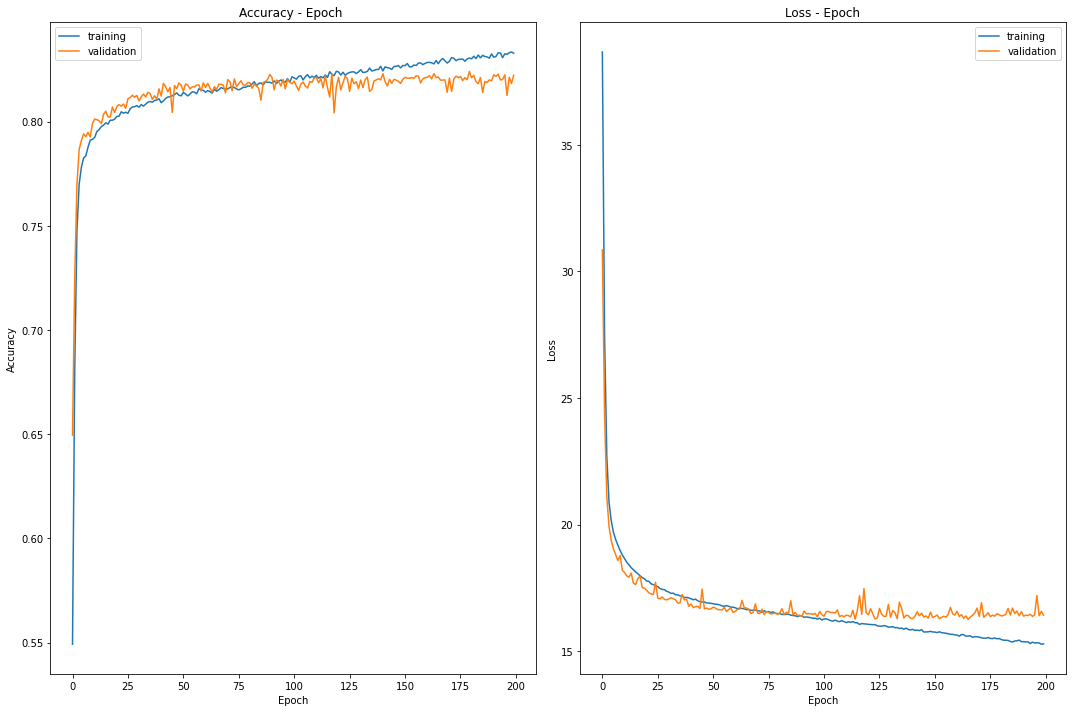

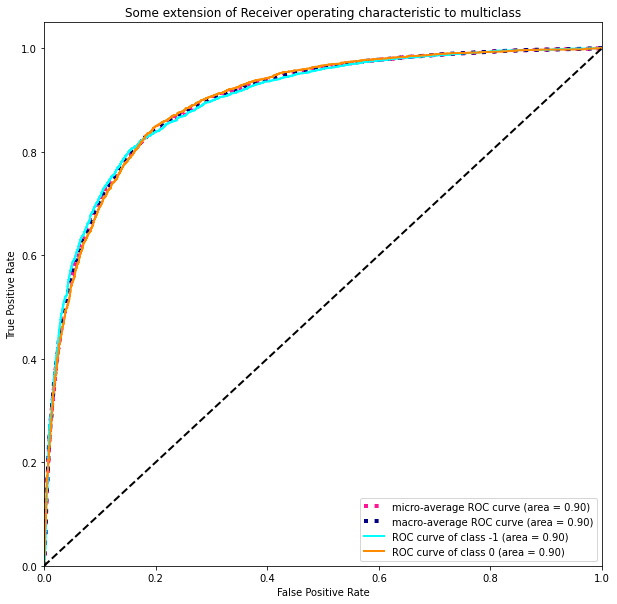

In [ ]:
#main starts here...

nltk.download('punkt')

#path for csv and glove6b files

dataPath ='drive/MyDrive/ColabNotebooks/haha/imdb-reviews.csv'
glove6btxtPath = 'drive/MyDrive/ColabNotebooks/haha/glove.6B.100d.txt'
maxLength = 100
print('\nShould take about 13-15 minutes to complete running ...\n')

dataset = pd.read_csv(dataPath,sep='\t')
#split dataset(80% for training and 20% for testing)
trainingData = dataset.sample(frac = 0.8, random_state = 25)
validationData = dataset.drop(trainingData.index)

embeddingsIndex = {}
#dictionary embeddingsIndex is fixed from glove6b text file
file = open(glove6btxtPath)

for line in file:

    rows = line.split()
    word = rows[0]
    value = np.asarray(rows[1:], dtype = 'float32')
    embeddingsIndex[word] = value

file.close()
#get x,y variables from filteringData function to create dataloaders
xTrainGlove, yTrain, xTestGlove, yTest = filteringData(trainingData, validationData)


#create neural network model and define parameters
D_in = xTrainGlove.shape[1]
H1 = 80
H2 = 40
H3 = 20
D_out = 2
learning_rate = 0.00016

#Initialize model, loss, optimizer
model = NeuralNetwork(D_in, H1, H2, H3, D_out)
lossFunction = nn.MSELoss(reduction = 'sum')
optimizer = torch.optim.NAdam(model.parameters(), lr = learning_rate)

trainingDataset = torch.utils.data.TensorDataset(xTrainGlove, yTrain)
trainingDataloader = torch.utils.data.DataLoader(trainingDataset, batch_size = 64, shuffle=True)
validationDataset = torch.utils.data.TensorDataset(xTestGlove, yTest)
validationDataloader = torch.utils.data.DataLoader(validationDataset, batch_size = 64, shuffle=True)

#list variables to save loss-accuracy from both training and validation
trainingLoss = []
trainingAccuracy = []
validationLoss = []
validationAccuracy = []

#repeat 200 times , better results for our model
for epoch in range(200):

    trainingBatchLosses = []
    trainingCheck = 0
#iterate dataloader to get batches , use forward function of our model , fix yBtach then call MSELoss function.
#Delete gradients , perform back propagation and update model's weights
    for xBatch, yBatch in trainingDataloader :

      yPred = model.forward(xBatch.float())
      yBatchn = label_binarize(yBatch, classes=[0,1])
      yBatchFix = fixBatchY(yBatchn)
      yBatchFix=torch.tensor(yBatchFix)
      trainLoss = lossFunction(yPred,yBatchFix.float())
      trainingBatchLosses.append(trainLoss.item())
      optimizer.zero_grad()
      trainLoss.backward()
      optimizer.step()

      yPred1D = to1D(yPred)

      yPred1D = torch.tensor(yPred1D)

      temp = (yBatch == yPred1D).float()
      trainingCheck += temp.sum() / len(temp)
#calculate and save loss and accuracy
    trainingLoss.append(sum(trainingBatchLosses)/len(trainingDataloader))
    trainingAccuracy.append(trainingCheck/len(trainingDataloader))


    validationBatchLosses = []
    validationCheck = 0
#iterate dataloader to get batches , use forward function of our model , fix yBtach then call MSELoss function.
    for xBatch, yBatch in validationDataloader:
        yPredValidation = model.forward(xBatch.float())
        yBatchn = label_binarize(yBatch, classes=[0, 1])
        yBatchFix = fixBatchY(yBatchn)
        yBatchFix = torch.tensor(yBatchFix)
        valLoss = lossFunction(yPredValidation,yBatchFix.float())
        validationBatchLosses.append(valLoss.item())

        yPred1DValidation = to1D(yPredValidation)

        yPred1DValidation = torch.tensor(yPred1DValidation)

        temp = (yBatch == yPred1DValidation).float()
        validationCheck += temp.sum() / len(temp)
#calculate and save loss and accuracy
    validationLoss.append(sum(validationBatchLosses)/len(validationDataloader))
    validationAccuracy.append(validationCheck/len(validationDataloader))
#calls function to plot all curves and stats
plottingCurves(yTest, trainingLoss, validationLoss, trainingAccuracy, validationAccuracy, xTestGlove, 2)